Question: How does the presence of irrelevant input attributes affect the performance of backpropagation learning? 

In [1]:
using CSV, DataFrames, Random, Plots, Statistics

In [7]:
#Preprocessing the data

data = CSV.read("water_potability.csv", DataFrame)
dropmissing!(data)
function min_max_scale!(df::DataFrame)
    for col in names(df)
        min_val = minimum(df[!, col])
        max_val = maximum(df[!, col])
        df[!, col] = (df[!, col] .- min_val) / (max_val - min_val)
    end
    return df
end
function standard_scale!(df::DataFrame)
    for col in names(df)[1:end-1]
        mean_val = mean(df[!, col])
        std_val = std(df[!, col])
        df[!, col] = (df[!, col] .- mean_val) ./ std_val
    end
    return df
end

min_max_scale!(data)
# transform!(data, :Potability => ByRow(x -> x == 0 ? -1 : x) => :Potability)
data.Potability = convert(Vector{Int8}, data.Potability)
class_0 = filter(row -> row.Potability == Int8(0), data)
class_1 = filter(row -> row.Potability == Int8(1), data)
test_size = Int(floor(size(class_1)[1] / 3))
testIndices1 = randperm(size(class_1, 1))[1:test_size]
testData = class_1[testIndices1, :] 
deleteat!(class_1, sort(testIndices1))
testIndices2 = randperm(size(class_0, 1))[1:test_size]
append!(testData, class_0[testIndices2, :])
deleteat!(class_0, sort(testIndices2))
trainData = vcat(class_0, class_1)
append!(trainData, class_1[randperm(size(class_1, 1))[1:size(class_0, 1) - size(class_1, 1)], :])

#Sanity Check - If classes are balanced in train and test data
@assert size(testData[testData.Potability .== Int8(0), :], 1) == size(testData[testData.Potability .== Int8(1), :], 1)
@assert size(trainData[trainData.Potability .== Int8(0), :], 1) == size(trainData[trainData.Potability .== Int8(1), :], 1)

trainX, trainY = trainData[!, [:ph, :Hardness, :Solids, :Chloramines, :Sulfate, :Conductivity, :Organic_carbon, :Trihalomethanes, :Turbidity]], trainData[!, :Potability]
testX, testY = testData[!, [:ph, :Hardness, :Solids, :Chloramines, :Sulfate, :Conductivity, :Organic_carbon, :Trihalomethanes, :Turbidity]], testData[!, :Potability]
trainX, trainY, testX, testY = Matrix{Float64}(trainX), Vector{Int8}(trainY), Matrix{Float64}(testX), Vector{Int8}(testY)

([0.5873491578253435 0.5777467079096754 … 0.7950293417620221 0.6301147622237924; 0.643653933181897 0.4413003450060942 … 0.20291434479028328 0.520358030988992; … ; 0.49476608439144953 0.42975304881287213 … 0.5603667796637536 0.32702247597311135; 0.5127055454055702 0.6581434519103609 … 0.20121651568596757 0.41258442087768576], Int8[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.4385043006932727 0.4688919836185837 … 0.44079011452380823 0.4366609556900267; 0.5817024501134267 0.5171393488940302 … 0.3971475113028898 0.32507541867564904; … ; 0.46340031452937586 0.58617267650912 … 0.2830966085823313 0.4240343037279443; 0.457504444949472 0.42423287116965774 … 0.7655935206664518 0.5180191635944549], Int8[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Train a h-h-1 feedforward NN (with one hidden layer containing as many nodes as the original input attributes) using sigmoid or tanh node functions, with the backpropagation algorithm, preferably with ADAM optimizer.  First experiment with a few choices for learning rate to ensure that accuracy does improve with training, and the training is not too slow—this is often a good idea before you start the actual experimental simulations with careful collection of results.

In [8]:
using Flux

function getConfusionMatrix(model, data)
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    for i in 1:size(data, 1)
        if model(data[i][1])[1] >= 0 && data[i][2][1] == Int8(1)
            tPos += 1
        elseif model(data[i][1])[1] >= 0 && data[i][2][1] == Int8(0)
            tNeg += 1
        elseif model(data[i][1])[1] < 0 && data[i][2][1] == Int8(1)
            fPos += 1
        elseif model(data[i][1])[1] < 0 && data[i][2][1] == Int8(0)
            fNeg += 1
        else
            throw(MethodError("Something went wrong"))
        end
    end
    return [tPos tNeg ; fPos fNeg]
end

function terminating_condition(epochs, accuracies)
    if epochs <= 1e3
        return true
    elseif epochs > 1e4
        return false
    else
        last10 = accuracies[end-9:end]
        diff = [last10[i + 1] - last10[i] for i in 1:length(last10) - 1]
        return !all(x -> x <= 0, diff)
    end
end

trainData = []
for i in range(start=1, stop=size(trainX, 1), step=1)
    push!(trainData, (trainX[i, :], [trainY[i]]))
end
testData = []
for i in range(start=1, stop=size(testX, 1), step=1)
    push!(testData, (testX[i, :], [testY[i]]))
end


In [9]:
function runModel(lr, trainData, testData, activation, lossFunction)
    model = Chain(
        Dense(size(trainData[1][1], 1) => 9, activation),
        Dense(9 => 1, tanh)
    )
    loss(x, y) = lossFunction(model(x), y) 
    optimizer = ADAM(lr)

    trainData, testData = shuffle(trainData), shuffle(testData)
    accuracies = []
    train_accuracies, test_accuracies = [], []
    epochs = 0
    best_accuracy, best_model = 0, nothing
    num_wt_updates = 0
    wt_updates = []

    while terminating_condition(epochs, accuracies)
        Flux.train!(loss, Flux.params(model), trainData, optimizer)
        num_wt_updates += sum(length, Flux.params(model))
        confusionMatrix = getConfusionMatrix(model, vcat(trainData, testData))
        accuracy = (confusionMatrix[1, 1] + confusionMatrix[2, 2]) / (sum(confusionMatrix))
        if accuracy > best_accuracy
            best_accuracy = accuracy
            best_model = model
        end
        push!(accuracies, accuracy)
        push!(wt_updates, log(num_wt_updates))
        trainConfusion = getConfusionMatrix(model, trainData)
        trainAccuracy = (trainConfusion[1, 1] + trainConfusion[2, 2]) / (sum(trainConfusion))
        testConfusion = getConfusionMatrix(model, testData)
        testAccuracy = (testConfusion[1, 1] + testConfusion[2, 2]) / (sum(testConfusion))
        push!(train_accuracies, trainAccuracy)
        push!(test_accuracies, testAccuracy)
        epochs += 1
    end
    return accuracies, epochs, best_accuracy, best_model, num_wt_updates, wt_updates, train_accuracies, test_accuracies
end

function avg_acc(v1::Vector, v2::Vector)
    len = max(length(v1), length(v2))
    result = zeros(len)

    for i in 1:len
        val1 = i <= length(v1) ? v1[i] : 0
        val2 = i <= length(v2) ? v2[i] : 0
        result[i] = val1 + val2
    end
    return result ./ 2
end

function gelu2(x)
    return (0.5 * (1.0 + tanh(sqrt(2.0 / π) * (x + 0.044715 * x^3))))^2
end

gelu2 (generic function with 1 method)

In [10]:
function create_plot(x, y_values, x_label, y_label, title, line_colors)
    p = plot(xlabel=x_label, ylabel=y_label, title=title, size=(1200, 800))
    labels = ["Accuracy", "Train Accuracy", "Test Accuracy"]
    for (i, y) in enumerate(y_values)
        plot!(p, x, y, label=labels[i], linecolor=line_colors[i], titlefontsize=10, xguidefontsize=5, yguidefontsize=5,
        xtickfontsize=5, ytickfontsize=5, legendfontsize=5)
    end
    return p
end

lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
plots = []
Gaccuracies, Gepochs, Gbest_accuracy, Gbest_model, Gnum_wt_updates, Gwt_updates, GtrainAccuracies, GtestAccuracies = [], [], [], [], [], [], [], []
for lr in lrs
    print("LR - ", lr)
    accuracies, epochs, best_accuracy, best_model, num_wt_updates, wt_updates, trainAccuracies, testAccuracies = runModel(lr, trainData, testData, tanh, Flux.Losses.logitbinarycrossentropy)
    
    title1 = "lr = $lr"
    plot1_ae = create_plot(1:length(accuracies), [accuracies, trainAccuracies, testAccuracies], "Epochs", "Accuracy", title1, [:blue, :red, :green])
    
    title2 = "lr = $lr"
    plot2_aw = create_plot(wt_updates, [accuracies, trainAccuracies, testAccuracies], "log(wt updates)", "Accuracy", title2, [:blue, :red, :green])
    
    push!(plots, plot1_ae)
    push!(plots, plot2_aw)

    push!(Gaccuracies, accuracies)
    push!(Gepochs, epochs)
    push!(Gbest_accuracy, best_accuracy)
    push!(Gbest_model, best_model)
    push!(Gnum_wt_updates, num_wt_updates)
    push!(Gwt_updates, wt_updates)
    push!(GtrainAccuracies, trainAccuracies)
    push!(GtestAccuracies, testAccuracies)
end


LR - 0.1

LR - 0.01

LR - 0.001

LR - 0.0001

LR - 1.0e-5

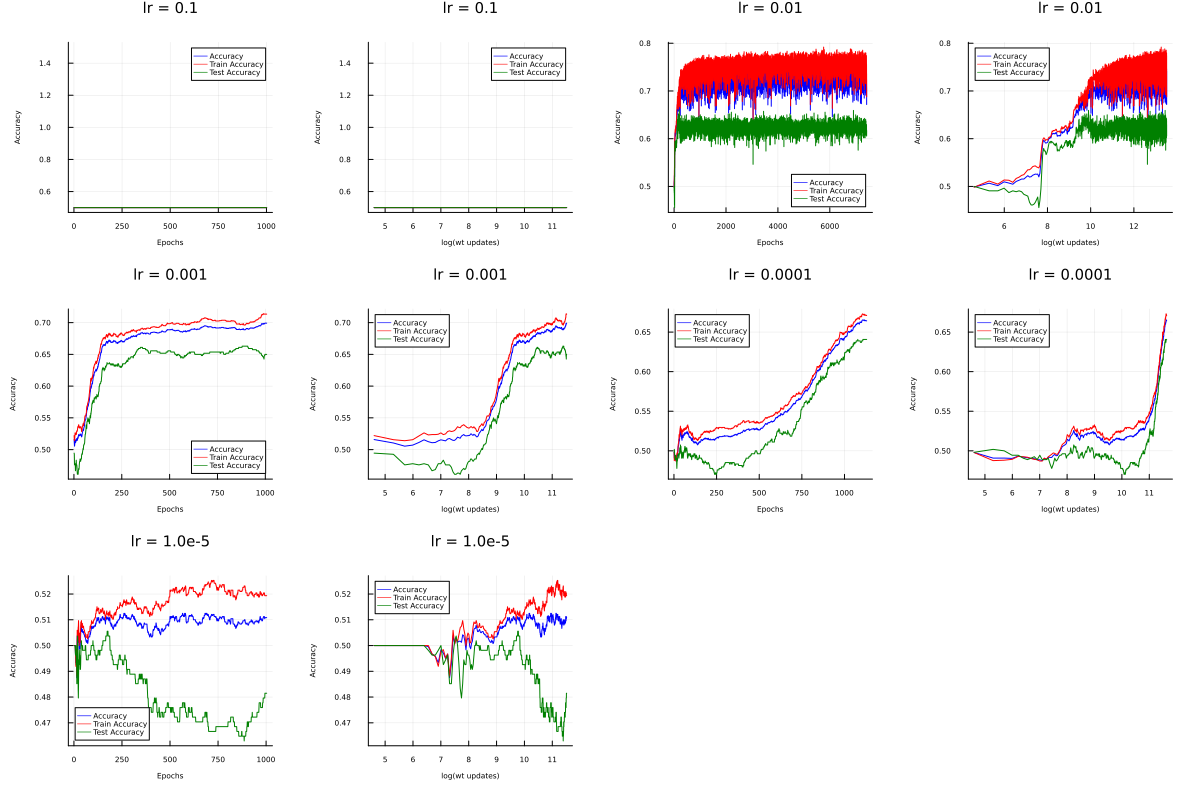

In [11]:
# Checking performance on different learning rates
plot(plots..., layout=10, margin=5*Plots.mm)

After each training iteration (epoch), record the accuracy on the training data, and also on the testing data. Terminate training when there is no improvement in accuracy on the training data over 10 epochs. Conduct ten different trials, starting with different randomly initialized networks; results shown should average over all ten trials.

In [44]:
avg_train_accuracy, avg_test_accuracy, wtUpdates = nothing, nothing, nothing
learningRate = 1e-2
bestAccuracy, bestModel = 0, nothing
for iter in 1:10
    println("Iteration $iter")
    accuracies, epochs, best_accuracy, best_model, num_wt_updates, wt_updates, trainAccuracies, testAccuracies = runModel(learningRate, trainData, testData, tanh, Flux.Losses.logitbinarycrossentropy)
    if best_accuracy > bestAccuracy
        bestAccuracy = best_accuracy
        bestModel = best_model
    end
    if iter == 1
        avg_train_accuracy, avg_test_accuracy = trainAccuracies, testAccuracies
        wtUpdates = wt_updates
    else
        avg_train_accuracy = avg_acc(avg_train_accuracy, trainAccuracies)
        avg_test_accuracy = avg_acc(avg_test_accuracy, testAccuracies)
        if wtUpdates[end] < wt_updates[end]
            wtUpdates = wt_updates
        end
    end
end


Iteration 1


Iteration 2


Iteration 3


Iteration 4


Iteration 5


Iteration 6


Iteration 7


Iteration 8


Iteration 9


Iteration 10


Add ten additional randomly generated input attributes to the inputs, selecting each value from a normal distribution with mean 0 and variance 1.

In [20]:
function add_noise(data)
    noisyData = copy(data)
    for idx in 1:length(data)
        noise = randn(10)
        datapoint, y = data[idx][1], data[idx][2]
        noisyData[idx] = (vcat(datapoint, noise), y)
    end
    return noisyData
end

noisyTrainData = add_noise(trainData)
noisyTestData = add_noise(testData)
println(size(noisyTrainData[1][1]), size(noisyTestData[1][1]))

(19,)(19,)


In [22]:
Noisy_avg_train_accuracy, Noisy_avg_test_accuracy, Noisy_wtUpdates = nothing, nothing, nothing
learningRate = 1e-2
Noisy_bestAccuracy, Noisy_bestModel = 0, nothing
for iter in 1:10
    println("Iteration $iter")
    accuracies, epochs, best_accuracy, best_model, num_wt_updates, wt_updates, trainAccuracies, testAccuracies = runModel(learningRate, noisyTrainData, noisyTestData, tanh, Flux.Losses.logitbinarycrossentropy)
    if best_accuracy > Noisy_bestAccuracy
        Noisy_bestAccuracy = best_accuracy
        Noisy_bestModel = best_model
    end
    if iter == 1
        Noisy_avg_train_accuracy, Noisy_avg_test_accuracy = trainAccuracies, testAccuracies
        Noisy_wtUpdates = wt_updates
    else
        Noisy_avg_train_accuracy = avg_acc(Noisy_avg_train_accuracy, trainAccuracies)
        Noisy_avg_test_accuracy = avg_acc(Noisy_avg_test_accuracy, testAccuracies)
        if Noisy_wtUpdates[end] < wt_updates[end]
            Noisy_wtUpdates = wt_updates
        end
    end
end

Iteration 1


Iteration 2


Iteration 3


Iteration 4


Iteration 5


Iteration 6


Iteration 7


Iteration 8


Iteration 9


Iteration 10


In [48]:
println("Best accuracy in Clean Data = $bestAccuracy\nBest accuracy in Noisy Data = $Noisy_bestAccuracy")

Best accuracy in Clean Data = 0.7583333333333333
Best accuracy in Noisy Data = 0.6908333333333333


In [50]:
c, n = wtUpdates[end], Noisy_wtUpdates[end]
println("Computational effort in Clean Data = $c\nComputational effort in Noisy Data = $n")

Computational effort in Clean Data = 13.815610552964607
Computational effort in Noisy Data = 14.457464439137002


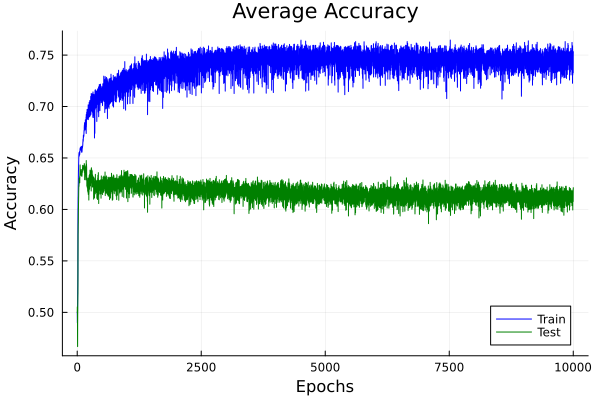

In [15]:
plot(1:length(avg_train_accuracy), avg_train_accuracy, xlabel="Epochs", ylabel="Accuracy", title="Average Accuracy (Clean)", linecolor=:blue, label="Train")
plot!(1:length(avg_test_accuracy), avg_test_accuracy, linecolor=:green, label="Test")

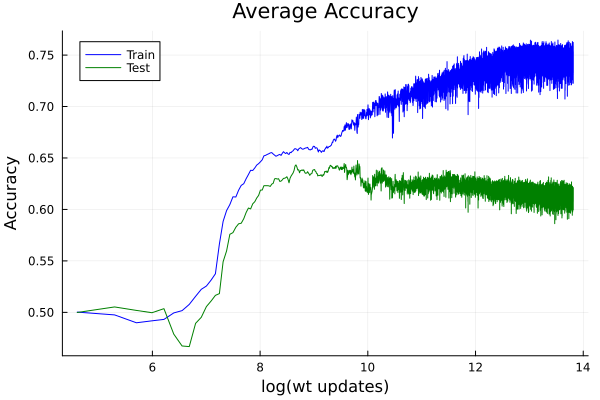

In [16]:
plot(wtUpdates, avg_train_accuracy, xlabel="log(wt updates)", ylabel="Accuracy", title="Average Accuracy (Clean)", linecolor=:blue, label="Train")
plot!(wtUpdates, avg_test_accuracy, linecolor=:green, label="Test")

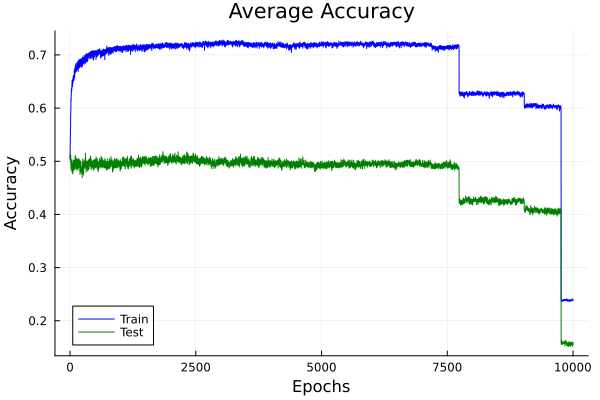

In [23]:
plot(1:length(Noisy_avg_train_accuracy), Noisy_avg_train_accuracy, xlabel="Epochs", ylabel="Accuracy", title="Average Accuracy (Noisy)", linecolor=:blue, label="Train")
plot!(1:length(Noisy_avg_test_accuracy), Noisy_avg_test_accuracy, linecolor=:green, label="Test")

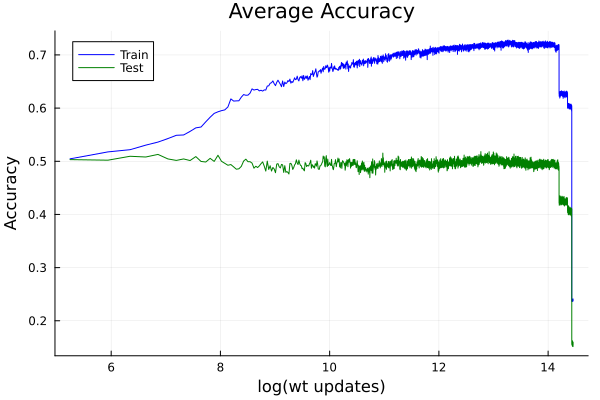

In [24]:
plot(Noisy_wtUpdates, Noisy_avg_train_accuracy, xlabel="log(wt updates)", ylabel="Accuracy", title="Average Accuracy (Noisy)", linecolor=:blue, label="Train")
plot!(Noisy_wtUpdates, Noisy_avg_test_accuracy, linecolor=:green, label="Test")

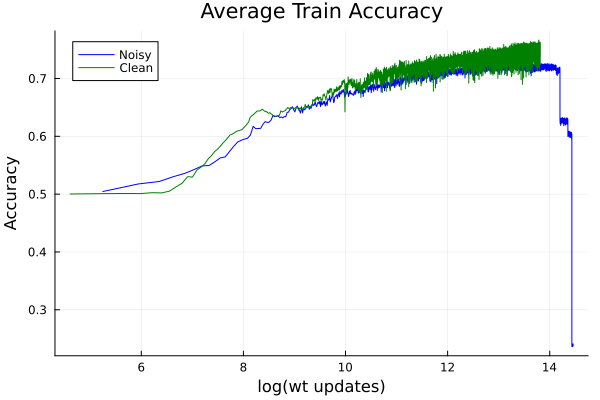

In [45]:
plot(Noisy_wtUpdates, Noisy_avg_train_accuracy, xlabel="log(wt updates)", ylabel="Accuracy", title="Average Train Accuracy", linecolor=:blue, label="Noisy")
plot!(wtUpdates, avg_train_accuracy, linecolor=:green, label="Clean")

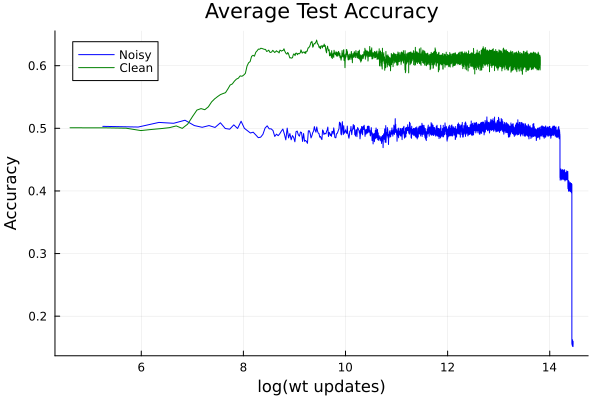

In [46]:
plot(Noisy_wtUpdates, Noisy_avg_test_accuracy, xlabel="log(wt updates)", ylabel="Accuracy", title="Average Test Accuracy", linecolor=:blue, label="Noisy")
plot!(wtUpdates, avg_test_accuracy, linecolor=:green, label="Clean")